## Model 7: Best Accuracy

In [1]:
#imports
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os
from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True' #needed this so that my kernel didn't die when plotting
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [16]:
#list of directories
base_directory = "../skin-cancer-mnist-ham10000"

test_directory = os.path.join(base_directory, 'image_data_test')
train_directory = os.path.join(base_directory, 'image_data_train')
validation_directory = os.path.join(base_directory, 'image_data_validation')
aug_train_directory = os.path.join(base_directory, 'image_data_train_augmented')
bal_validation_directory = os.path.join(base_directory, 'image_data_validation_balanced')

In [3]:
#importing pre-trained model
from keras.applications import MobileNetV2

In [5]:
#assigning model to variable to add to new model
#top fully connected layers not included
prior = MobileNetV2(include_top =  False, weights = "imagenet", input_shape = (150, 150, 3))

In [6]:
model = Sequential()

model.add(prior)

model.add(Flatten())
# model.add(Dropout(rate = 0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

#freeze MobileNet layers so that imagenet weights can be used
for layer in model.layers[0].layers:
    layer.trainable = False

W0825 21:51:11.575375 4574565824 deprecation.py:506] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16384512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [8]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['acc'])

W0825 21:51:11.749882 4574565824 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
#class weights used to give more emphasis to the melanomic classes
class_weights = {
    0: 1,
    1: 1,
    2: 2,
    3: 1,
    4: 1,
    5: 1,
    6: 2
}

In [17]:
#largest target size used for images
#increasing batch size made a difference
train_generator = train_datagen.flow_from_directory(
        aug_train_directory,
        target_size=(150, 150), 
        batch_size= 256,
        class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
        bal_validation_directory,
        target_size=(150, 150),
        batch_size= 256,
        class_mode='categorical')

Found 26273 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 150, 150, 3)
labels batch shape: (256, 7)


In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor= "val_loss", patience = 5, restore_best_weights= True),
             ReduceLROnPlateau(monitor="loss", patience = 2)]


In [20]:
import numpy as np

#important to make sure steps are related to the batch size and image count
history = model.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(26273/256),
      epochs=20,
      validation_data=validation_generator,
      validation_steps= np.ceil(196/256),
      callbacks= callbacks,
      class_weight= class_weights
)

W0825 21:53:23.866266 4574565824 deprecation.py:323] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
103/103 [==============================] - 1130s 11s/step - loss: 2.4226 - acc: 0.2957 - val_loss: 1.5499 - val_acc: 0.3980
Epoch 2/20
103/103 [==============================] - 1294s 13s/step - loss: 1.7342 - acc: 0.4923 - val_loss: 1.5453 - val_acc: 0.4694
Epoch 3/20
103/103 [==============================] - 1324s 13s/step - loss: 1.5029 - acc: 0.5785 - val_loss: 1.5849 - val_acc: 0.4643
Epoch 4/20
103/103 [==============================] - 1314s 13s/step - loss: 1.3170 - acc: 0.6411 - val_loss: 1.5455 - val_acc: 0.5153
Epoch 5/20
103/103 [==============================] - 1318s 13s/step - loss: 1.2081 - acc: 0.6767 - val_loss: 1.4874 - val_acc: 0.5255
Epoch 6/20
103/103 [==============================] - 1328s 13s/step - loss: 1.0800 - acc: 0.7133 - val_loss: 1.8452 - val_acc: 0.5204
Epoch 7/20
103/103 [==============================] - 1393s 14s/step - loss: 0.9853 - acc: 0.7377 - val_loss: 1.7061 - val_acc: 0.5102
Epoch 8/20
103/103 [==============================] - 1

In [21]:
model.save("model_7.h5")

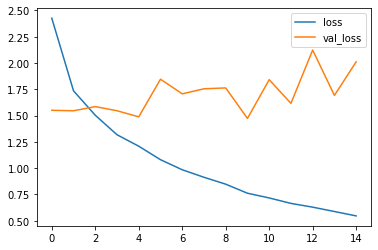

In [22]:
#plot of loss for train and val
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend();

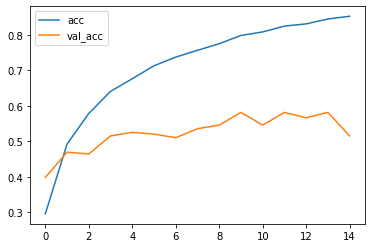

In [23]:
#plot of accuracy for train and val
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend();

## Summary:

This is the best that a model has performed so far with the balanced validation data. There is clear overfitting and I am not sure why the model is not learning past a certain point. Slowing the learning rate down seems only to have helped the training data, not the testing data. After reading about batch size influence, manipulating the batch size to be larger than 32 definitely increased accuracy. In the future, I would like to use a platform like AWS to run my more time consuming models so that I can use a larger input image and run more tests. 